In [1070]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

In [1071]:
bigrams.head()

,custom_id,"(000,jobs)","(100,days)","(116th,congress)","(2019,congressional)","(21st,century)","(6,million)","(9,11)","(abortion,survivors)","(access,quality)",...,"(watch,live)","(white,house)","(women,act)",name,party,position,score_0,score_115,score_116,state
0,263,0,2,0,0,1,0,0,0,0,...,0,2,0,Abby Finkenauer,D,H,0.000000,NaN,0.000000,Iowa 1st District
1,516,0,7,2,2,3,0,0,0,1,...,4,0,0,Abigail Spanberger,D,H,0.000000,NaN,0.000000,Virginia 7th District
2,242,1,0,0,1,0,0,0,0,0,...,1,1,0,Adam Kinzinger,R,H,0.934426,0.989583,0.730769,Illinois 16th District
3,142,0,0,0,0,0,0,3,0,0,...,0,9,0,Adam Schiff,D,H,0.178862,0.229167,0.000000,California 28th District
4,528,0,0,0,1,0,0,0,0,2,...,0,0,1,Adam Smith,D,H,0.111111,0.144444,0.000000,Washington 9th District


In [1072]:
bigrams = pd.read_csv("bigram_count.csv")
df = bigrams[pd.notnull(bigrams["score_0"])]
bigrams[["custom_id","(000,jobs)", "(100,days)", "(abortion,survivors)", "name", "party", "position", "score_0", "state"]].head()

,custom_id,"(000,jobs)","(100,days)","(abortion,survivors)",name,party,position,score_0,state
0,263,0,2,0,Abby Finkenauer,D,H,0.000000,Iowa 1st District
1,516,0,7,0,Abigail Spanberger,D,H,0.000000,Virginia 7th District
2,242,1,0,0,Adam Kinzinger,R,H,0.934426,Illinois 16th District
3,142,0,0,0,Adam Schiff,D,H,0.178862,California 28th District
4,528,0,0,0,Adam Smith,D,H,0.111111,Washington 9th District


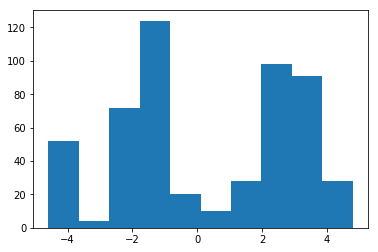

In [1073]:
# df["score_0"].hist()
score2 = df["score_0"]
score2[score2==0] += 0.01
score2[score2==1] -= 0.01
plt.hist(np.log(df["score_0"] / (1-df["score_0"])))
plt.show()

# min(df["score_0"])
# df[df["party"]=="D"]["score_0"].hist()
# plt.show()
# df[df["party"]=="R"]["score_0"].hist()
# plt.show()

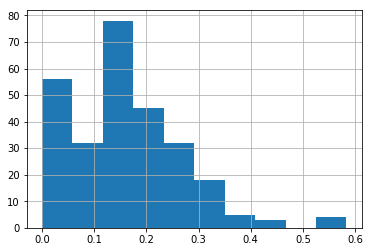

In [1074]:
bigrams[bigrams["party"] == "D"]["score_0"].hist()
plt.show()

In [1075]:
bigs = df.columns[1:201]

In [1076]:
df[bigs].sum().sort_values(ascending=False)[:10]

(health,care)             2222
(american,people)         1534
(president,trump)         1455
(look,forward)            1108
(climate,change)          1041
(mueller,report)           916
(town,hall)                893
(looking,forward)          870
(trump,administration)     842
(pre,existing)             685
dtype: int64

In [1077]:
r = df[df["party"]=="R"][bigs].sum()
r.head()

(000,jobs)              186
(100,days)               84
(116th,congress)        137
(2019,congressional)     85
(21st,century)           69
dtype: int64

In [1078]:
d = df[df["party"]=="D"][bigs].sum()
d.head()

(000,jobs)               18
(100,days)              241
(116th,congress)        158
(2019,congressional)     81
(21st,century)           99
dtype: int64

In [1079]:
a = abs(r - d).sort_values(ascending=False)

In [1080]:
i = a[a > 200].index.values

In [1082]:
rb = r.sort_values(ascending=False)
db = d.sort_values(ascending=False)

In [1083]:
s = set(rb.index.values) | set(db.index.values)

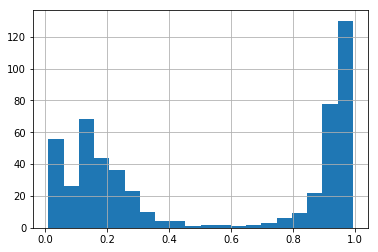

In [1085]:
df["score_0"].hist(bins=20)

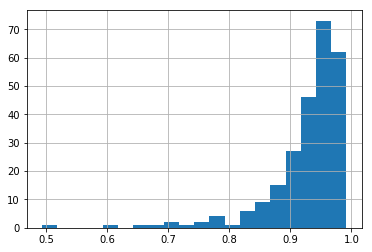

In [1086]:
df[df["party"]=="R"]["score_0"].hist(bins=20)

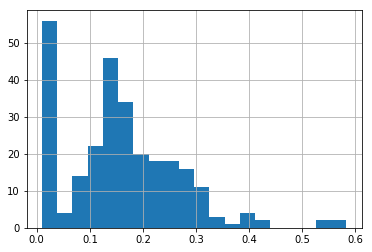

In [1087]:
df[df["party"]=="D"]["score_0"].hist(bins=20)

(array([ 62.,  85.,  68.,  45.,   9.,   3.,   5.,   5.,  19., 226.]),
 array([0.00995033, 0.07786268, 0.14577504, 0.21368739, 0.28159974,
        0.34951209, 0.41742445, 0.4853368 , 0.55324915, 0.6211615 ,
        0.68907386]),
 <a list of 10 Patch objects>)

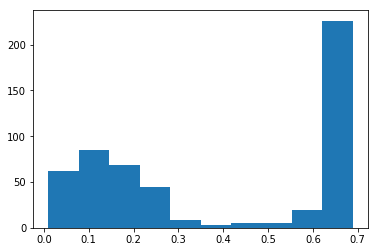

In [1088]:
plt.hist(np.log(df["score_0"] + 1))

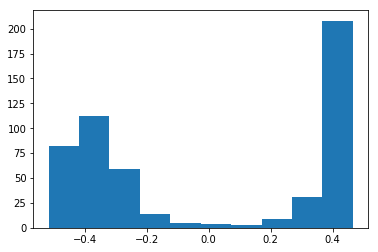

In [1089]:
diff = df["score_0"] - df["score_0"].mean()
plt.hist(diff)
plt.show()

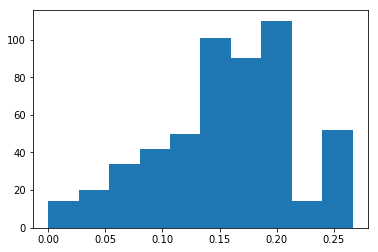

In [1090]:
diffsq = diff ** 2
plt.hist(diffsq)
plt.show()

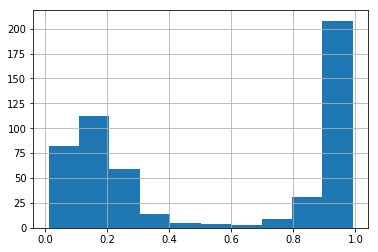

In [1092]:
df["score_0"].hist()

In [1094]:
reps = []
dems = []

rt = []
dt = []
rscores = []
for b in bigs:
    rtotal = df[df["party"]=="R"][b].sum()
    dtotal = df[df["party"]=="D"][b].sum()
    total = rtotal + dtotal
    rscore = rtotal / total
    if (rscore >= 0.60):
        reps.append(b)
    elif (rscore <= 0.40):
        dems.append(b)
    rt.append(rtotal)
    dt.append(dtotal)
    rscores.append(rscore)

In [1096]:
dfr = df[reps].sum(1)
dfd = df[dems].sum(1)
df2 = pd.DataFrame({"reps": dfr, "dems": dfd, "party": df["party"], "score": df["score_0"]})
df2.head()


,reps,dems,party,score
0,3,41,D,0.010000
1,4,50,D,0.010000
2,31,16,R,0.934426
3,6,119,D,0.178862
4,6,97,D,0.111111


In [1098]:
bigsdf = pd.DataFrame({"bigram": bigs, "rtotal": rt, "dtotal": dt, "rscore": rscores})
bigsdf["r_lean"] = np.where((bigsdf["rscore"] >= 0.60) & (bigsdf["rscore"] < 0.75), 1, 0)
bigsdf["r_solid"] = np.where(bigsdf["rscore"] >= 0.75, 1, 0)
bigsdf["d_lean"] = np.where((bigsdf["rscore"] <= 0.40) & (bigsdf["rscore"] > 0.25), 1, 0)
bigsdf["d_solid"] = np.where(bigsdf["rscore"] <= 0.25, 1, 0)

In [1099]:
bigsdf.head()

,bigram,rtotal,dtotal,rscore,r_lean,r_solid,d_lean,d_solid
0,"(000,jobs)",186,18,0.911765,0,1,0,0
1,"(100,days)",84,241,0.258462,0,0,1,0
2,"(116th,congress)",137,158,0.464407,0,0,0,0
3,"(2019,congressional)",85,81,0.512048,0,0,0,0
4,"(21st,century)",69,99,0.410714,0,0,0,0


In [1100]:
r_lean = df[bigsdf[bigsdf["r_lean"] == 1]["bigram"].values].sum(1)
r_solid = df[bigsdf[bigsdf["r_solid"] == 1]["bigram"].values].sum(1)
d_lean = df[bigsdf[bigsdf["d_lean"] == 1]["bigram"].values].sum(1)
d_solid = df[bigsdf[bigsdf["d_solid"] == 1]["bigram"].values].sum(1)
total = r_lean + r_solid + d_lean + d_solid

df_leans = pd.DataFrame({
    "custom_id": df["custom_id"], "name": df["name"], "party": df["party"], "position": df["position"], 
    "r_lean": r_lean, "r_solid": r_solid, "d_lean": d_lean, "d_solid": d_solid, "total": total, "label": label,
    "score": df["score_0"]
})

df_leans.loc[(df_leans["score"] >= 0.5) & (df_leans["score"] < 0.85), "label"] = "leans_r"
df_leans.loc[(df_leans["score"] >= 0.85), "label"] = "solid_r"
df_leans.loc[(df_leans["score"] < 0.50) & (df_leans["score"] >= 0.15), "label"] = "leans_d"
df_leans.loc[(df_leans["score"] < 0.15), "label"] = "solid_d"
df_leans.head()


,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,total,label,score
0,263,Abby Finkenauer,D,H,3,0,15,26,44,solid_d,0.010000
1,516,Abigail Spanberger,D,H,2,2,31,19,54,solid_d,0.010000
2,242,Adam Kinzinger,R,H,13,18,14,2,47,solid_r,0.934426
3,142,Adam Schiff,D,H,2,4,74,45,125,leans_d,0.178862
4,528,Adam Smith,D,H,3,3,31,66,103,solid_d,0.111111


In [1101]:
test = df_leans.iloc[:400]
valid = df_leans.iloc[400:]

cols = ["r_lean", "r_solid", "d_lean", "d_solid"]
model = LinearRegression()
model.fit(test[cols], test["score"])
print(model.score(test[cols], test["score"]))
valid["pred"]  = model.predict(valid[cols])
valid.head()

0.6873014104282393


,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,total,label,score,pred
410,431,Tom Marino,R,H,5,4,19,27,55,solid_r,0.979167,0.429681
411,166,Tom McClintock,R,H,6,4,7,1,18,leans_r,0.844262,0.635520
412,110,Tom O’Halleran,D,H,8,1,15,32,56,leans_d,0.422764,0.417120
413,375,Tom Reed,R,H,11,19,17,25,72,solid_r,0.932203,0.652554
414,456,Tom Rice,R,H,31,58,33,19,141,solid_r,0.942149,1.267482


In [1102]:
test = df_leans.iloc[:400]
valid = df_leans.iloc[400:]

cols = ["r_lean", "r_solid", "d_lean", "d_solid", "total"]
model = LogisticRegression()
model.fit(test[cols], test["label"])
valid["pred"]  = model.predict(valid[cols])
valid.head()

,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,total,label,score,pred
410,431,Tom Marino,R,H,5,4,19,27,55,solid_r,0.979167,solid_d
411,166,Tom McClintock,R,H,6,4,7,1,18,leans_r,0.844262,solid_r
412,110,Tom O’Halleran,D,H,8,1,15,32,56,leans_d,0.422764,solid_d
413,375,Tom Reed,R,H,11,19,17,25,72,solid_r,0.932203,solid_r
414,456,Tom Rice,R,H,31,58,33,19,141,solid_r,0.942149,solid_r


In [1103]:
df_leans2 = df_leans.copy()
df_leans2["r_lean"] = np.log(df_leans["r_lean"] + 1)
df_leans2["d_lean"] = np.log(df_leans["d_lean"] + 1)
df_leans2["r_solid"] = np.log(df_leans["r_solid"] + 1)
df_leans2["d_solid"] = np.log(df_leans["d_solid"] + 1)
df_leans2.head()

,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,total,label,score
0,263,Abby Finkenauer,D,H,1.386294,0.000000,2.772589,3.295837,44,solid_d,0.010000
1,516,Abigail Spanberger,D,H,1.098612,1.098612,3.465736,2.995732,54,solid_d,0.010000
2,242,Adam Kinzinger,R,H,2.639057,2.944439,2.708050,1.098612,47,solid_r,0.934426
3,142,Adam Schiff,D,H,1.098612,1.609438,4.317488,3.828641,125,leans_d,0.178862
4,528,Adam Smith,D,H,1.386294,1.386294,3.465736,4.204693,103,solid_d,0.111111


In [1104]:
test = df_leans2.iloc[:400]
valid = df_leans2.iloc[400:]

cols = ["r_lean", "r_solid", "d_lean", "d_solid"]
model = LinearRegression()
model.fit(test[cols], test["score"])
print(model.score(test[cols], test["score"]))
valid["pred"]  = model.predict(valid[cols])
valid.head()

0.8042027752315564


,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,total,label,score,pred
410,431,Tom Marino,R,H,1.791759,1.609438,2.995732,3.332205,55,solid_r,0.979167,0.387958
411,166,Tom McClintock,R,H,1.945910,1.609438,2.079442,0.693147,18,leans_r,0.844262,0.877593
412,110,Tom O’Halleran,D,H,2.197225,0.693147,2.772589,3.496508,56,leans_d,0.422764,0.257558
413,375,Tom Reed,R,H,2.484907,2.995732,2.890372,3.258097,72,solid_r,0.932203,0.646693
414,456,Tom Rice,R,H,3.465736,4.077537,3.526361,2.995732,141,solid_r,0.942149,0.915937


In [1105]:
test = df_leans.iloc[:400]
valid = df_leans.iloc[400:]

cols = ["r_lean", "r_solid", "d_lean", "d_solid"]
model = LinearRegression()
model.fit(test[cols], test["score"])
valid["pred"]  = model.predict(valid[cols])
valid.loc[(valid["pred"] >= 0.5) & (valid["pred"] < 0.85), "p"] = "leans_r"
valid.loc[(valid["pred"] >= 0.85), "p"] = "solid_r"
valid.loc[(valid["pred"] < 0.50) & (valid["pred"] >= 0.15), "p"] = "leans_d"
valid.loc[(valid["pred"] < 0.15), "p"] = "solid_d"
valid.head()

,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,total,label,score,pred,p
410,431,Tom Marino,R,H,5,4,19,27,55,solid_r,0.979167,0.429681,leans_d
411,166,Tom McClintock,R,H,6,4,7,1,18,leans_r,0.844262,0.635520,leans_r
412,110,Tom O’Halleran,D,H,8,1,15,32,56,leans_d,0.422764,0.417120,leans_d
413,375,Tom Reed,R,H,11,19,17,25,72,solid_r,0.932203,0.652554,leans_r
414,456,Tom Rice,R,H,31,58,33,19,141,solid_r,0.942149,1.267482,solid_r


In [1106]:
# plt.hist((df_leans["score"] - df_leans["score"].mean()), bins=20)
df_leans["score_sq"] = np.square(df_leans["score"] - df_leans["score"].mean())
df_leans["score_adj"] = (df_leans["score"] - df_leans["score"].mean())

test = df_leans.iloc[:400]
valid = df_leans.iloc[400:]

cols = ["r_lean", "r_solid", "d_lean", "d_solid"]
model = LinearRegression()
model.fit(test[cols], test["score_sq"])
print(model.score(test[cols], test["score_sq"]))
valid["pred"]  = model.predict(valid[cols])
# valid.loc[(valid["pred"] >= 0.5) & (valid["pred"] < 0.85), "p"] = "leans_r"
# valid.loc[(valid["pred"] >= 0.85), "p"] = "solid_r"
# valid.loc[(valid["pred"] < 0.50) & (valid["pred"] >= 0.15), "p"] = "leans_d"
# valid.loc[(valid["pred"] < 0.15), "p"] = "solid_d"
valid.head()

0.01167273440500749


,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,total,label,score,score_sq,score_adj,pred
410,431,Tom Marino,R,H,5,4,19,27,55,solid_r,0.979167,0.205241,0.453036,0.162341
411,166,Tom McClintock,R,H,6,4,7,1,18,leans_r,0.844262,0.101208,0.318131,0.159857
412,110,Tom O’Halleran,D,H,8,1,15,32,56,leans_d,0.422764,0.010685,-0.103367,0.163193
413,375,Tom Reed,R,H,11,19,17,25,72,solid_r,0.932203,0.164895,0.406073,0.169982
414,456,Tom Rice,R,H,31,58,33,19,141,solid_r,0.942149,0.173071,0.416018,0.193317


In [1107]:
b2 = bigrams.copy()
b2r = b2[b2["party"]=="R"]
b2d = b2[b2["party"]=="D"]
for i, b in enumerate(bigs):
    b2r[b] = np.where(b2r[b] >= 1, 1, 0)
    b2d[b] = np.where(b2d[b] >= 1, 1, 0)
    if i % 20 == 0:
        print(i)

0
20
40
60
80
100
120
140
160
180


In [1108]:
b2ds = b2d[bigs].sum()
b2rs = b2r[bigs].sum()

In [1109]:
reps2 = []
dems2 = []

rt2 = []
dt2 = []
rscores2 = []
for b in bigs:
    rtotal = b2rs[b]
    dtotal = b2ds[b]
    total = rtotal + dtotal
    rscore = rtotal / total
    if (rscore >= 0.60):
        reps2.append(b)
    elif (rscore <= 0.40):
        dems2.append(b)
    rt2.append(rtotal)
    dt2.append(dtotal)
    rscores2.append(rscore)

In [1110]:
bigsdf2 = pd.DataFrame({"bigram": bigs, "rtotal": rt2, "dtotal": dt2, "rscore": rscores, "rscore2": rscores2, "diff": abs(np.array(rscores) - np.array(rscores2))})
bigsdf2["r_lean"] = np.where((bigsdf2["rscore2"] >= 0.60) & (bigsdf2["rscore"] < 0.75), 1, 0)
bigsdf2["r_solid"] = np.where(bigsdf2["rscore2"] >= 0.75, 1, 0)
bigsdf2["d_lean"] = np.where((bigsdf2["rscore2"] <= 0.40) & (bigsdf2["rscore"] > 0.25), 1, 0)
bigsdf2["d_solid"] = np.where(bigsdf2["rscore2"] <= 0.25, 1, 0)
bigsdf2.head()

,bigram,rtotal,dtotal,rscore,rscore2,diff,r_lean,r_solid,d_lean,d_solid
0,"(000,jobs)",117,20,0.911765,0.854015,0.057750,0,1,0,0
1,"(100,days)",45,115,0.258462,0.281250,0.022788,0,0,1,0
2,"(116th,congress)",85,100,0.464407,0.459459,0.004947,0,0,0,0
3,"(2019,congressional)",48,53,0.512048,0.475248,0.036801,0,0,0,0
4,"(21st,century)",47,64,0.410714,0.423423,0.012709,0,0,0,0


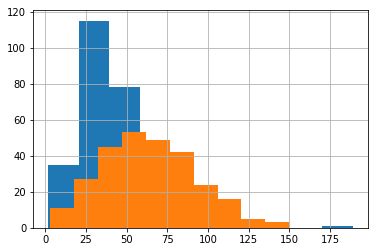

In [1187]:
r_lean = df[bigsdf2[bigsdf2["r_lean"] == 1]["bigram"].values].sum(1)
r_solid = df[bigsdf2[bigsdf2["r_solid"] == 1]["bigram"].values].sum(1)
d_lean = df[bigsdf2[bigsdf2["d_lean"] == 1]["bigram"].values].sum(1)
d_solid = df[bigsdf2[bigsdf2["d_solid"] == 1]["bigram"].values].sum(1)
total = r_lean + r_solid + d_lean + d_solid

df_leans2 = pd.DataFrame({
    "custom_id": df["custom_id"], "name": df["name"], "is_rep": np.where(df["party"] == "R", 1, 0), "position": df["position"], 
    "r_lean": r_lean, "r_solid": r_solid, "rt": r_lean + r_solid, 
    "d_lean": d_lean, "d_solid": d_solid, "dt": d_lean + d_solid,
    "total": total, "score": df["score_0"]
})

# df_leans2["label"] = ((df_leans2["score"] - 0) * (3 - 0)) / ((1 - 0) + 0)

# (c - a) * (z - y) / (b - a) + y
# df_leans2.loc[(df_leans2["score"] >= 0.5) & (df_leans2["score"] < 0.85), "label"] = 2.0
# df_leans2.loc[(df_leans2["score"] >= 0.85), "label"] = 3.0
# df_leans2.loc[(df_leans2["score"] < 0.50) & (df_leans2["score"] >= 0.15), "label"] = 1.0
# df_leans2.loc[(df_leans2["score"] < 0.15), "label"] = 0.0
df_leans2.head()
df_leans2[df_leans2["is_rep"]==1]["total"].hist()
df_leans2[df_leans2["is_rep"]==0]["total"].hist()

In [1205]:
def scale(x, min_num, max_num, scale_min=0, scale_max=1):
    return (x - min_num) * (scale_max - scale_min) / (max_num - min_num) + scale_min
# (X_test["pred_score"] - min(X_test["pred_score"])) * (1 - 0) / (max(X_test["pred_score"]) - min(X_test["pred_score"])) + 0


In [1243]:

X_train, X_test, y_train, y_test = train_test_split(df_leans2, df_leans2["is_rep"], test_size=0.25)
X_train["dli"] = 1 / X_train["d_lean"]
cols = ["rt", "dt"]

# test = df_leans2.iloc[:300]
# valid = df_leans2.iloc[300:]
# test[test["score"]==0] += 0.0001
# test[test["score"]==1] -= 0.0001
# valid[valid["score"]==0] += 0.0001
# valid[valid["score"]==1] -= 0.0001


# model = LogisticRegression()
model = LogisticRegression()
model.fit(X_train[cols], y_train)
print(model.score(X_train[cols], y_train))

X_train["pred_rep"] = model.predict(X_train[cols])
X_test["pred_rep"] = model.predict(X_test[cols])
print(sum(X_test["is_rep"] == X_test["pred_rep"]) / len(X_test["pred_rep"]))
X_test.head()

0.9493670886075949
0.9015151515151515


,custom_id,name,is_rep,position,r_lean,r_solid,rt,d_lean,d_solid,dt,total,score,pred_rep
85,311,Daniel Kildee,0,H,2,0,2,52,45,97,99,0.158333,0
488,80,Lindsey Graham,1,S,1,0,1,13,0,13,14,0.903226,0
56,439,Brendan Boyle,0,H,4,0,4,35,66,101,105,0.157025,0
299,238,Mike Bost,1,H,9,18,27,16,2,18,45,0.975410,1
230,353,Josh Gottheimer,0,H,1,0,1,9,4,13,14,0.430894,0


In [1244]:
cols = ["r_lean", "r_solid", "d_lean", "d_solid", "pred_rep"]
model = LinearRegression()

model.fit(X_train[cols], y_train)

print(model.score(X_train[cols], (y_train)))


X_test["pred_score"] = model.predict(X_test[cols])
X_test["pred_score"] = scale(X_test["pred_score"], min(X_test["pred_score"]), max(X_test["pred_score"]), 0, 1)

X_train["pred_score"] = model.predict(X_train[cols])
X_train["pred_score"] = scale(X_train["pred_score"], min(X_train["pred_score"]), max(X_train["pred_score"]), 0, 1)
X_test.head()

0.8245624648900485


,custom_id,name,is_rep,position,r_lean,r_solid,rt,d_lean,d_solid,dt,total,score,pred_rep,pred_score
85,311,Daniel Kildee,0,H,2,0,2,52,45,97,99,0.158333,0,0.149256
488,80,Lindsey Graham,1,S,1,0,1,13,0,13,14,0.903226,0,0.245741
56,439,Brendan Boyle,0,H,4,0,4,35,66,101,105,0.157025,0,0.074682
299,238,Mike Bost,1,H,9,18,27,16,2,18,45,0.975410,1,0.956675
230,353,Josh Gottheimer,0,H,1,0,1,9,4,13,14,0.430894,0,0.227553


[[1.         0.84998401]
 [0.84998401 1.        ]]


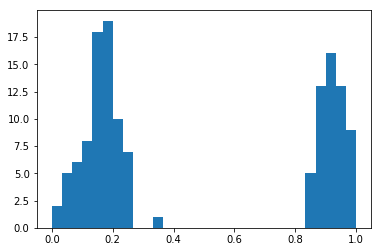

In [1247]:
print(np.corrcoef(X_test["score"], X_test["pred_score"]))
plt.hist(X_test["pred_score"], bins=30)
# plt.hist(X_test["score"], bins=30)
plt.show()

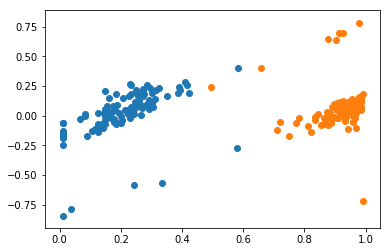

In [1246]:
resd = valid[valid["is_rep"]==0]["score"] - valid[valid["is_rep"]==0]["pred_score"]
resr = valid[valid["is_rep"]==1]["score"] - valid[valid["is_rep"]==1]["pred_score"]

plt.scatter(valid[valid["is_rep"]==0]["score"], resd)
plt.scatter(valid[valid["is_rep"]==1]["score"], resr)
plt.show()

In [983]:
cols = ["r_lean", "r_solid", "d_lean", "d_solid"]
X_train, X_test, y_train, y_test = train_test_split(
    df_leans2[cols], df_leans2["is_repub"], test_size=0.25)

log_ress = LogisticRegression().fit(X_train, y_train)
print(log_ress.score(X_train, y_train))
# cols.append(log_ress.predict(X_test))
p = log_ress.predict(X_test)
# lin_reg = LinearRegression().fit()
sum(p == y_test) / len(y_test)

0.9518987341772152


0.9545454545454546

In [984]:
scores = cross_val_score(log_ress, df_leans2[cols], df_leans2["is_repub"], cv=10)
scores


array([0.96296296, 0.94444444, 0.96226415, 0.94339623, 0.96226415,
       0.96153846, 1.        , 0.92307692, 0.94230769, 0.90384615])

In [985]:
xtrains = []
xtest = []
ytrains = []
ytests = []
preds = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
    df_leans2[cols], df_leans2["is_repub"], test_size=0.25)
    preds.append(log_ress.predict(X_test))
    xtrains.append(X_train)
    xtest.append(X_test)
    ytrains.append(y_train)
    ytests.append(y_test)

In [986]:
bigsdf2[bigsdf2["d_lean"]==1][["bigram", "rscore2", "d_lean"]].head()

,bigram,rscore2,d_lean
1,"(100,days)",0.281250,1
9,"(act,2019)",0.352381,1
17,"(american,families)",0.383333,1
25,"(bipartisan,bill)",0.396341,1
34,"(care,system)",0.313559,1


In [966]:
journdf = pd.read_csv("journalist_bigram_count.csv")
journdf.head()

,custom_id,"(000,jobs)","(100,days)","(116th,congress)","(2019,congressional)","(21st,century)","(6,million)","(9,11)","(abortion,survivors)","(access,quality)",...,"(watch,live)","(white,house)","(women,act)",name,party,position,score_0,score_115,score_116,state
0,2001,0,0,0,0,0,0,0,0,0,...,0,9,0,Benjamin Weiser,D,J,d_solid,NaN,NaN,nytimes
1,2002,0,0,0,0,0,0,0,0,0,...,0,1,0,Azam Ahmed,D,J,d_solid,NaN,NaN,nytimes
2,2004,0,0,0,0,0,0,0,0,0,...,0,0,0,Maria Russo,D,J,d_solid,NaN,NaN,nytimes
3,2005,0,0,0,0,0,0,0,0,0,...,0,0,0,megan twohey,D,J,d_solid,NaN,NaN,nytimes
4,2006,0,0,0,0,0,0,0,0,0,...,0,1,0,Patrick J. Lyons,D,J,d_solid,NaN,NaN,nytimes


In [967]:
j_rlean = np.quantile(df_leans2[df_leans2["is_repub"]==1]["score"], 0.20)
j_rsolid = np.quantile(df_leans2[df_leans2["is_repub"]==1]["score"], 0.80)
j_dlean = np.quantile(df_leans2[df_leans2["is_repub"]==0]["score"], 0.80)
j_dsolid = np.quantile(df_leans2[df_leans2["is_repub"]==0]["score"], 0.20)

In [968]:
journ_r_lean = journdf[bigsdf2[bigsdf2["r_lean"] == 1]["bigram"].values].sum(1)
journ_r_solid = journdf[bigsdf2[bigsdf2["r_solid"] == 1]["bigram"].values].sum(1)
journ_d_lean = journdf[bigsdf2[bigsdf2["d_lean"] == 1]["bigram"].values].sum(1)
journ_d_solid = journdf[bigsdf2[bigsdf2["d_solid"] == 1]["bigram"].values].sum(1)
journ_total = journ_r_lean + journ_r_solid + journ_d_lean + journ_d_solid


journ_leans = pd.DataFrame({
    "custom_id": journdf["custom_id"], "name": journdf["name"], "is_repub": np.where(journdf["party"] == "R", 1, 0), "position": journdf["position"], 
    "r_lean": journ_r_lean, "r_solid": journ_r_solid, "d_lean": journ_d_lean, "d_solid": journ_d_solid, "total": journ_total, "lean": journdf["score_0"]
})

In [969]:
journ_leans[journ_leans["is_repub"]==1].head()

,custom_id,name,is_repub,position,r_lean,r_solid,d_lean,d_solid,total,lean
59,2061,"Marion E Mass, M.D.",1,J,1,0,2,2,5,r_lean
60,2062,Kay Coles James,1,J,2,28,10,22,62,r_lean
61,2063,Bridget Johnson ☘️,1,J,0,0,15,0,15,r_lean
62,2064,MarkWeinberg,1,J,0,0,13,1,14,r_lean
63,2065,Scott W. Atlas,1,J,3,1,2,3,9,r_lean


In [970]:
journ_leans.loc[journ_leans["lean"]=="r_lean", "score"] = j_rlean
journ_leans.loc[journ_leans["lean"]=="r_solid", "score"] = j_rsolid
journ_leans.loc[journ_leans["lean"]=="d_lean", "score"] = j_dlean
journ_leans.loc[journ_leans["lean"]=="d_solid", "score"] = j_dsolid
journ_leans.drop(columns="lean", inplace=True)
journ_leans.dropna(subset=["score"], inplace=True)
journ_leans.head()

,custom_id,name,is_repub,position,r_lean,r_solid,d_lean,d_solid,total,score
0,2001,Benjamin Weiser,0,J,0,0,15,2,17,0.037037
1,2002,Azam Ahmed,0,J,0,2,4,1,7,0.037037
2,2004,Maria Russo,0,J,0,0,0,0,0,0.037037
3,2005,megan twohey,0,J,0,0,7,3,10,0.037037
4,2006,Patrick J. Lyons,0,J,0,0,4,1,5,0.037037


In [971]:
# for c in ["r_lean", "r_solid", "d_lean", "d_solid", "total"]:
#     journ_leans[c] = journ_leans[c] * 5

In [972]:
cols = ["r_lean", "r_solid", "d_lean", "d_solid"]

journ_party_pred = (log_ress.predict(journ_leans[cols]))
sum(journ_party_pred == journ_leans["is_repub"]) / len(journ_leans["is_repub"])
journ_leans["pred_rep"] = journ_party_pred


cols = ["r_lean", "r_solid", "d_lean", "d_solid", "pred_rep"]
journ_leans["pred_score"]  = model.predict(journ_leans[cols])
# pd.DataFrame({"party": journ_leans["is_repub"], "pred": journ_party_pred})



In [973]:
journ_leans["total"].describe()

count    78.000000
mean     11.551282
std      12.315809
min       0.000000
25%       4.000000
50%       8.000000
75%      15.000000
max      62.000000
Name: total, dtype: float64

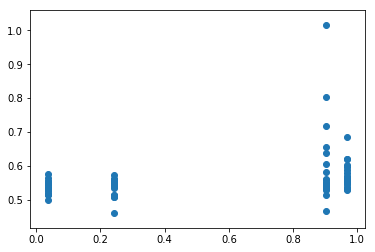

In [974]:
plt.scatter(journ_leans["score"], journ_leans["pred_score"])

In [975]:
np.corrcoef(journ_leans["score"], journ_leans["pred_score"])

array([[1.        , 0.33431477],
       [0.33431477, 1.        ]])